In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Load the CO2 Concentration Dataset

Source: https://github.com/yaringal/DropoutUncertaintyCaffeModels/tree/master/co2_regression/data

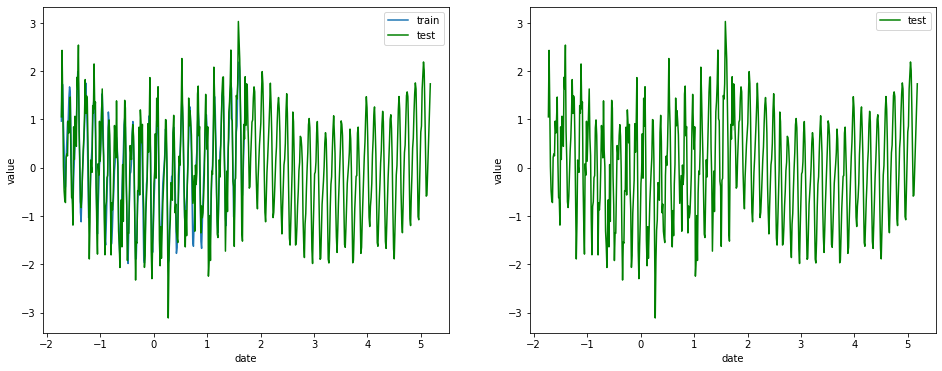

In [2]:
# data = np.loadtxt('data/co2_mm_mlo.txt')
# signal = pd.DataFrame(data[:, [2, 4]], columns=['date', 'average'])

import h5py

with h5py.File("data/co2/co2_train.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1)
    signal_train = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

with h5py.File("data/co2/co2_test.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1) * 0
    signal_test = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

signal_train_noisy = signal_train.copy()
signal_train_noisy.value = signal_train_noisy.value + .5 * np.random.randn(signal_train_noisy.shape[0])
# signal_test = pd.concat([signal_train_noisy, signal_test], axis=0).reset_index(drop=True)

signal_train_shifted = signal_train.copy()
signal_train_shifted.date = signal_train_shifted.date + (signal_train_shifted.date.max() - signal_train_shifted.date.min())
signal_test = pd.concat([signal_train_noisy, signal_train_shifted], axis=0).reset_index(drop=True)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sb.lineplot(ax=ax[0], x='date', y='value', data=signal_train, label='train')
sb.lineplot(ax=ax[0], x='date', y='value', color='g', data=signal_test, label='test')
ax[0].legend()
sb.lineplot(ax=ax[1], x='date', y='value', color='g', data=signal_test, label='test')
ax[1].legend();

In [3]:
# stl = STL(train_labels, period=12, seasonal=7)
# stl_result = stl.fit()
# stl_result.plot()

In [4]:
train_labels = signal_train.value
train_data = np.hstack([signal_train.date.to_numpy().reshape(-1, 1)])
test_labels = signal_test.value
test_data = np.hstack([signal_test.date.to_numpy().reshape(-1, 1)])

In [5]:
train_data.shape, test_data.shape

((272, 1), (544, 1))

((272, 1), (272,))

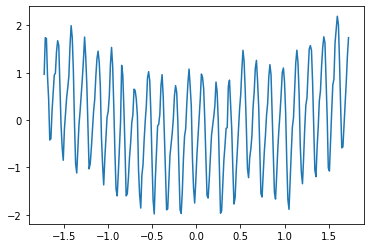

In [6]:
# train_data = train_data[:12*21, :]
# train_labels = np.array(train_labels[:12*21])
test_data = train_data
test_labels = train_labels

batch_size = 256
train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
plt.plot(train_data, train_labels)
train_data.shape, train_labels.shape
# type(train_data), type(train_labels)

## [Training Model and Configuration](#Training-Model-and-Configuration)

In [7]:
hidden_layers = [1000, 1000, 1000, 1000]
dropout = 0
lr = 0.001
tau = 1
wd = 0.000005 #  0.01**2 * (1 - dropout) / (2. * len(train_loader) * tau)

model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=hidden_layers, dropout=dropout, batch_norm=True)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
model.net

Sequential(
  (0): Linear(in_features=1, out_features=1000, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1000, out_features=1000, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1000, out_features=1000, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=1000, out_features=1, bias=True)
)

In [8]:
reset_loss_every = 100
n_epochs = 1600
device = "cpu"
model.to(device)
model.train()

def set_bn_eval(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.eval()

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0
    
    model.train()
    for it, batch in enumerate(train_loader):
        data, target = batch
        
        if len(target) < batch_size:
#             print(f"it: {it} -> eval mode for BN")
#             model.apply(set_bn_eval)
            continue

        optimizer.zero_grad()
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        num_samples += len(target)
        loss_epoch += loss.item() * len(target)
        loss.backward()
        optimizer.step()
        
    print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")
    
    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

epoch: 0, num_samples: 256, average_loss: 1.0574352741241455
epoch: 1, num_samples: 256, average_loss: 1.3537291288375854
epoch: 2, num_samples: 256, average_loss: 0.9098365306854248
epoch: 3, num_samples: 256, average_loss: 0.8845861554145813
epoch: 4, num_samples: 256, average_loss: 0.8347548246383667
epoch: 5, num_samples: 256, average_loss: 0.7899958491325378
epoch: 6, num_samples: 256, average_loss: 0.8055852055549622
epoch: 7, num_samples: 256, average_loss: 0.734560489654541
epoch: 8, num_samples: 256, average_loss: 0.772686243057251
epoch: 9, num_samples: 256, average_loss: 0.7308438420295715
epoch: 10, num_samples: 256, average_loss: 0.7104486227035522
epoch: 11, num_samples: 256, average_loss: 0.7535924315452576
epoch: 12, num_samples: 256, average_loss: 0.6625816226005554
epoch: 13, num_samples: 256, average_loss: 0.6766418218612671
epoch: 14, num_samples: 256, average_loss: 0.6623069643974304
epoch: 15, num_samples: 256, average_loss: 0.6535549163818359
epoch: 16, num_sampl

epoch: 133, num_samples: 256, average_loss: 0.36690136790275574
epoch: 134, num_samples: 256, average_loss: 0.30683016777038574
epoch: 135, num_samples: 256, average_loss: 0.3059893250465393
epoch: 136, num_samples: 256, average_loss: 0.34918487071990967
epoch: 137, num_samples: 256, average_loss: 0.4207073748111725
epoch: 138, num_samples: 256, average_loss: 0.7737506628036499
epoch: 139, num_samples: 256, average_loss: 1.184641718864441
epoch: 140, num_samples: 256, average_loss: 0.8412273526191711
epoch: 141, num_samples: 256, average_loss: 0.7292013764381409
epoch: 142, num_samples: 256, average_loss: 0.6908743977546692
epoch: 143, num_samples: 256, average_loss: 0.7251444458961487
epoch: 144, num_samples: 256, average_loss: 0.6851029396057129
epoch: 145, num_samples: 256, average_loss: 0.6646019220352173
epoch: 146, num_samples: 256, average_loss: 0.5644447803497314
epoch: 147, num_samples: 256, average_loss: 0.5672824382781982
epoch: 148, num_samples: 256, average_loss: 0.5697010

epoch: 264, num_samples: 256, average_loss: 0.6041282415390015
epoch: 265, num_samples: 256, average_loss: 0.5599380135536194
epoch: 266, num_samples: 256, average_loss: 0.5713655948638916
epoch: 267, num_samples: 256, average_loss: 0.5103891491889954
epoch: 268, num_samples: 256, average_loss: 0.5327595472335815
epoch: 269, num_samples: 256, average_loss: 0.49408191442489624
epoch: 270, num_samples: 256, average_loss: 0.4875732958316803
epoch: 271, num_samples: 256, average_loss: 0.4856838285923004
epoch: 272, num_samples: 256, average_loss: 0.43193429708480835
epoch: 273, num_samples: 256, average_loss: 0.4539506435394287
epoch: 274, num_samples: 256, average_loss: 0.44497132301330566
epoch: 275, num_samples: 256, average_loss: 0.4111630320549011
epoch: 276, num_samples: 256, average_loss: 0.44879525899887085
epoch: 277, num_samples: 256, average_loss: 0.4274364709854126
epoch: 278, num_samples: 256, average_loss: 0.4340961277484894
epoch: 279, num_samples: 256, average_loss: 0.39548

epoch: 394, num_samples: 256, average_loss: 0.24265797436237335
epoch: 395, num_samples: 256, average_loss: 0.28513476252555847
epoch: 396, num_samples: 256, average_loss: 0.3913094103336334
epoch: 397, num_samples: 256, average_loss: 0.2231762409210205
epoch: 398, num_samples: 256, average_loss: 0.22660082578659058
epoch: 399, num_samples: 256, average_loss: 0.36108335852622986
epoch: 400, num_samples: 256, average_loss: 0.29499828815460205
epoch: 401, num_samples: 256, average_loss: 0.28064659237861633
epoch: 402, num_samples: 256, average_loss: 0.287118524312973
epoch: 403, num_samples: 256, average_loss: 0.2987995147705078
epoch: 404, num_samples: 256, average_loss: 0.23308470845222473
epoch: 405, num_samples: 256, average_loss: 0.2506532669067383
epoch: 406, num_samples: 256, average_loss: 0.287280410528183
epoch: 407, num_samples: 256, average_loss: 0.25324976444244385
epoch: 408, num_samples: 256, average_loss: 0.20709793269634247
epoch: 409, num_samples: 256, average_loss: 0.22

epoch: 524, num_samples: 256, average_loss: 0.1628318578004837
epoch: 525, num_samples: 256, average_loss: 0.2000730037689209
epoch: 526, num_samples: 256, average_loss: 0.1485610008239746
epoch: 527, num_samples: 256, average_loss: 0.15789572894573212
epoch: 528, num_samples: 256, average_loss: 0.19305330514907837
epoch: 529, num_samples: 256, average_loss: 0.18509380519390106
epoch: 530, num_samples: 256, average_loss: 0.12129510939121246
epoch: 531, num_samples: 256, average_loss: 0.13485419750213623
epoch: 532, num_samples: 256, average_loss: 0.1428118348121643
epoch: 533, num_samples: 256, average_loss: 0.12882162630558014
epoch: 534, num_samples: 256, average_loss: 0.15267351269721985
epoch: 535, num_samples: 256, average_loss: 0.1077338382601738
epoch: 536, num_samples: 256, average_loss: 0.16851994395256042
epoch: 537, num_samples: 256, average_loss: 0.14802436530590057
epoch: 538, num_samples: 256, average_loss: 0.2580178380012512
epoch: 539, num_samples: 256, average_loss: 0.

epoch: 654, num_samples: 256, average_loss: 0.14232832193374634
epoch: 655, num_samples: 256, average_loss: 0.08061670511960983
epoch: 656, num_samples: 256, average_loss: 0.12783297896385193
epoch: 657, num_samples: 256, average_loss: 0.11781541258096695
epoch: 658, num_samples: 256, average_loss: 0.11449380218982697
epoch: 659, num_samples: 256, average_loss: 0.10828971862792969
epoch: 660, num_samples: 256, average_loss: 0.16022296249866486
epoch: 661, num_samples: 256, average_loss: 0.15623067319393158
epoch: 662, num_samples: 256, average_loss: 0.12102828174829483
epoch: 663, num_samples: 256, average_loss: 0.15865249931812286
epoch: 664, num_samples: 256, average_loss: 0.14718791842460632
epoch: 665, num_samples: 256, average_loss: 0.1251489520072937
epoch: 666, num_samples: 256, average_loss: 0.1458864063024521
epoch: 667, num_samples: 256, average_loss: 0.14310485124588013
epoch: 668, num_samples: 256, average_loss: 0.1244058907032013
epoch: 669, num_samples: 256, average_loss:

epoch: 784, num_samples: 256, average_loss: 0.08977091312408447
epoch: 785, num_samples: 256, average_loss: 0.07599703222513199
epoch: 786, num_samples: 256, average_loss: 0.08863024413585663
epoch: 787, num_samples: 256, average_loss: 0.11920038610696793
epoch: 788, num_samples: 256, average_loss: 0.08902502059936523
epoch: 789, num_samples: 256, average_loss: 0.05568604916334152
epoch: 790, num_samples: 256, average_loss: 0.08132458478212357
epoch: 791, num_samples: 256, average_loss: 0.09664872288703918
epoch: 792, num_samples: 256, average_loss: 0.10003559291362762
epoch: 793, num_samples: 256, average_loss: 0.07131203263998032
epoch: 794, num_samples: 256, average_loss: 0.06719911098480225
epoch: 795, num_samples: 256, average_loss: 0.05049406737089157
epoch: 796, num_samples: 256, average_loss: 0.08027371764183044
epoch: 797, num_samples: 256, average_loss: 0.09123577922582626
epoch: 798, num_samples: 256, average_loss: 0.053314004093408585
epoch: 799, num_samples: 256, average_l

epoch: 913, num_samples: 256, average_loss: 0.019132860004901886
epoch: 914, num_samples: 256, average_loss: 0.03827245533466339
epoch: 915, num_samples: 256, average_loss: 0.020999282598495483
epoch: 916, num_samples: 256, average_loss: 0.04480660334229469
epoch: 917, num_samples: 256, average_loss: 0.034415602684020996
epoch: 918, num_samples: 256, average_loss: 0.017203297466039658
epoch: 919, num_samples: 256, average_loss: 0.03075900301337242
epoch: 920, num_samples: 256, average_loss: 0.0318465419113636
epoch: 921, num_samples: 256, average_loss: 0.027093952521681786
epoch: 922, num_samples: 256, average_loss: 0.05059778690338135
epoch: 923, num_samples: 256, average_loss: 0.06567784398794174
epoch: 924, num_samples: 256, average_loss: 0.034305915236473083
epoch: 925, num_samples: 256, average_loss: 0.05294876545667648
epoch: 926, num_samples: 256, average_loss: 0.07070009410381317
epoch: 927, num_samples: 256, average_loss: 0.058075353503227234
epoch: 928, num_samples: 256, aver

epoch: 1040, num_samples: 256, average_loss: 0.013394209556281567
epoch: 1041, num_samples: 256, average_loss: 0.020300865173339844
epoch: 1042, num_samples: 256, average_loss: 0.022980134934186935
epoch: 1043, num_samples: 256, average_loss: 0.027201425284147263
epoch: 1044, num_samples: 256, average_loss: 0.030650226399302483
epoch: 1045, num_samples: 256, average_loss: 0.03371173143386841
epoch: 1046, num_samples: 256, average_loss: 0.026570647954940796
epoch: 1047, num_samples: 256, average_loss: 0.024412788450717926
epoch: 1048, num_samples: 256, average_loss: 0.02714860625565052
epoch: 1049, num_samples: 256, average_loss: 0.020332740619778633
epoch: 1050, num_samples: 256, average_loss: 0.022447330877184868
epoch: 1051, num_samples: 256, average_loss: 0.021183663979172707
epoch: 1052, num_samples: 256, average_loss: 0.016278399154543877
epoch: 1053, num_samples: 256, average_loss: 0.016440564766526222
epoch: 1054, num_samples: 256, average_loss: 0.015643445774912834
epoch: 1055,

epoch: 1166, num_samples: 256, average_loss: 0.03426497429609299
epoch: 1167, num_samples: 256, average_loss: 0.03330754488706589
epoch: 1168, num_samples: 256, average_loss: 0.03321317583322525
epoch: 1169, num_samples: 256, average_loss: 0.03548242524266243
epoch: 1170, num_samples: 256, average_loss: 0.02551138959825039
epoch: 1171, num_samples: 256, average_loss: 0.02770885080099106
epoch: 1172, num_samples: 256, average_loss: 0.021513910964131355
epoch: 1173, num_samples: 256, average_loss: 0.024318303912878036
epoch: 1174, num_samples: 256, average_loss: 0.02575182355940342
epoch: 1175, num_samples: 256, average_loss: 0.031992264091968536
epoch: 1176, num_samples: 256, average_loss: 0.03033319301903248
epoch: 1177, num_samples: 256, average_loss: 0.01829339750111103
epoch: 1178, num_samples: 256, average_loss: 0.033813320100307465
epoch: 1179, num_samples: 256, average_loss: 0.03240831196308136
epoch: 1180, num_samples: 256, average_loss: 0.017644375562667847
epoch: 1181, num_sam

epoch: 1293, num_samples: 256, average_loss: 0.020709969103336334
epoch: 1294, num_samples: 256, average_loss: 0.015072262845933437
epoch: 1295, num_samples: 256, average_loss: 0.016593340784311295
epoch: 1296, num_samples: 256, average_loss: 0.01910053938627243
epoch: 1297, num_samples: 256, average_loss: 0.021081797778606415
epoch: 1298, num_samples: 256, average_loss: 0.020547596737742424
epoch: 1299, num_samples: 256, average_loss: 0.014639370143413544
epoch: 1300, num_samples: 256, average_loss: 0.012808638624846935
epoch: 1301, num_samples: 256, average_loss: 0.02742897905409336
epoch: 1302, num_samples: 256, average_loss: 0.029885461553931236
epoch: 1303, num_samples: 256, average_loss: 0.02037286013364792
epoch: 1304, num_samples: 256, average_loss: 0.04283573850989342
epoch: 1305, num_samples: 256, average_loss: 0.015570007264614105
epoch: 1306, num_samples: 256, average_loss: 0.02631884440779686
epoch: 1307, num_samples: 256, average_loss: 0.024150552228093147
epoch: 1308, nu

epoch: 1418, num_samples: 256, average_loss: 0.016499163582921028
epoch: 1419, num_samples: 256, average_loss: 0.018304571509361267
epoch: 1420, num_samples: 256, average_loss: 0.026539597660303116
epoch: 1421, num_samples: 256, average_loss: 0.01937100477516651
epoch: 1422, num_samples: 256, average_loss: 0.026063071563839912
epoch: 1423, num_samples: 256, average_loss: 0.016062002629041672
epoch: 1424, num_samples: 256, average_loss: 0.027878206223249435
epoch: 1425, num_samples: 256, average_loss: 0.02750232443213463
epoch: 1426, num_samples: 256, average_loss: 0.0191400907933712
epoch: 1427, num_samples: 256, average_loss: 0.02367684245109558
epoch: 1428, num_samples: 256, average_loss: 0.018588507547974586
epoch: 1429, num_samples: 256, average_loss: 0.028752218931913376
epoch: 1430, num_samples: 256, average_loss: 0.016874659806489944
epoch: 1431, num_samples: 256, average_loss: 0.013365357182919979
epoch: 1432, num_samples: 256, average_loss: 0.021672483533620834
epoch: 1433, nu

epoch: 1543, num_samples: 256, average_loss: 0.015309017151594162
epoch: 1544, num_samples: 256, average_loss: 0.017236176878213882
epoch: 1545, num_samples: 256, average_loss: 0.012603077106177807
epoch: 1546, num_samples: 256, average_loss: 0.015308883041143417
epoch: 1547, num_samples: 256, average_loss: 0.01667599193751812
epoch: 1548, num_samples: 256, average_loss: 0.0162547267973423
epoch: 1549, num_samples: 256, average_loss: 0.015816815197467804
epoch: 1550, num_samples: 256, average_loss: 0.00999665167182684
epoch: 1551, num_samples: 256, average_loss: 0.016374621540308
epoch: 1552, num_samples: 256, average_loss: 0.01576532982289791
epoch: 1553, num_samples: 256, average_loss: 0.011584259569644928
epoch: 1554, num_samples: 256, average_loss: 0.009889929555356503
epoch: 1555, num_samples: 256, average_loss: 0.017569206655025482
epoch: 1556, num_samples: 256, average_loss: 0.008848645724356174
epoch: 1557, num_samples: 256, average_loss: 0.016948582604527473
epoch: 1558, num_s

In [9]:
optimizer.param_groups[0]['lr']

0.00025

(272,)
Test mse_loss = 0.0771874412894249


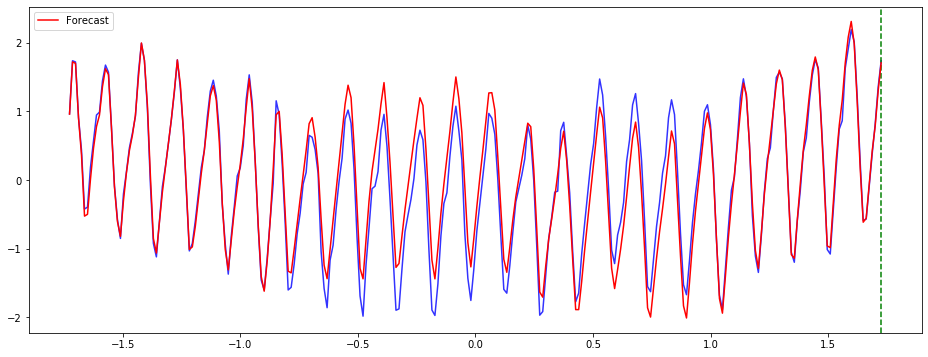

In [10]:
model.to(device)

# model.train()
model.eval()

ensemble_size = 10

gt = []
forecast = []
for it, batch in enumerate(test_loader):
    data, target = batch
    output = []
    for ensemble_it in range(ensemble_size):
        output.append(model(data.float().to(device)).data.numpy())
    output = np.hstack(output)
    forecast.append(output)
    gt.append(target.view(-1).data.numpy())
    
forecast = np.vstack(forecast)
predictive_mean = forecast.mean(1)
predictive_std = forecast.std(1)
print(predictive_mean.shape)
# print(predictive_std)
gt = np.hstack(gt)
mse_loss = ((gt - predictive_mean)**2).mean()
print(f"Test mse_loss = {mse_loss}")

fig, axes = plt.subplots(figsize=(16, 6))
axes.plot(train_data.squeeze(), train_labels.squeeze(), 'b', alpha=0.8);
axes.axvline(train_data.squeeze()[-1], color='g',linestyle='--');
axes.plot(test_data.squeeze(), predictive_mean, color='r', label="Forecast")
# axes.fill_between(test_data.squeeze(), predictive_mean-2*predictive_std, predictive_mean+2*predictive_std, label='prediction interval', color='g', alpha=0.9);
axes.legend();

Repeat the above training+evaluation experiment for two different values of DropourRate={0, 0.5} in the [Training-Model-and-Configuration](http://localhost:8888/notebooks/uncertainty_regression.ipynb#Training-Model-and-Configuration) cell (above) and see how that single change introduces the prediction interval.